### Загрузка датасета

In [2]:
import cv2
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.optimizers import Adam
import zipfile
import os

from google.colab import files
uploaded = files.upload()

with zipfile.ZipFile('/content/images.zip', 'r') as zip_ref:
    zip_ref.extractall()

train_path = pathlib.Path("images_small")
val_path = pathlib.Path("test_small")

img_h = 224
img_w = 224

train_data = tf.keras.utils.image_dataset_from_directory(train_path)
val_data = tf.keras.utils.image_dataset_from_directory(val_path)
class_labels = dict(zip(train_data.class_names, range(len(train_data.class_names))))
num_labels = len(class_labels)

Found 1650 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


### Предобработка изображений

In [3]:
augmenter = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

train_gen = augmenter.flow_from_directory(train_path,
                                          target_size=(img_h, img_w),
                                          color_mode="rgb",
                                          class_mode="categorical",
                                          batch_size=32,
                                          shuffle=True,
                                          seed=123)

val_gen = augmenter.flow_from_directory(val_path,
                                        target_size=(img_h, img_w),
                                        color_mode="rgb",
                                        class_mode="categorical",
                                        batch_size=32,
                                        shuffle=True,
                                        seed=123)


Found 1650 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


### Создание и настройка модели

In [4]:
base_model = MobileNetV2(
    input_shape=(img_h, img_w, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg')

base_model.trainable = False

input_tensor = base_model.input
x = Dense(128, activation='relu')(base_model.output)
x = Dense(128, activation='relu')(x)
output_tensor = Dense(num_labels, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

### Компиляция модели

In [5]:
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    verbose=1,
    restore_best_weights=True,
)
model_ckpt = ModelCheckpoint('best_model.keras',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

callbacks_list = [early_stop, model_ckpt]

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


### Обучение модели

In [6]:
hist = model.fit(
    train_gen, validation_data=val_gen,
    epochs=20,
    callbacks=callbacks_list)

Epoch 1/20
52/52 [==============================] - 108s 2s/step - loss: 0.6141 - accuracy: 0.8145 - val_loss: 0.3709 - val_accuracy: 0.8900
Epoch 2/20
52/52 [==============================] - 96s 2s/step - loss: 0.2094 - accuracy: 0.9297 - val_loss: 0.2099 - val_accuracy: 0.9200
Epoch 3/20
52/52 [==============================] - 117s 2s/step - loss: 0.1764 - accuracy: 0.9418 - val_loss: 0.2446 - val_accuracy: 0.9050
Epoch 4/20
52/52 [==============================] - 128s 2s/step - loss: 0.1311 - accuracy: 0.9570 - val_loss: 0.2467 - val_accuracy: 0.9100
Epoch 4: early stopping


### Оценка модели

In [7]:
(eval_loss, eval_acc) = model.evaluate(val_gen)

train_loss_vals = hist.history['loss']
val_loss_vals = hist.history['val_loss']
train_acc_vals = hist.history['accuracy']
val_acc_vals = hist.history['val_accuracy']

7/7 [==============================] - 14s 2s/step - loss: 0.2429 - accuracy: 0.9200


### Визуализация результатов

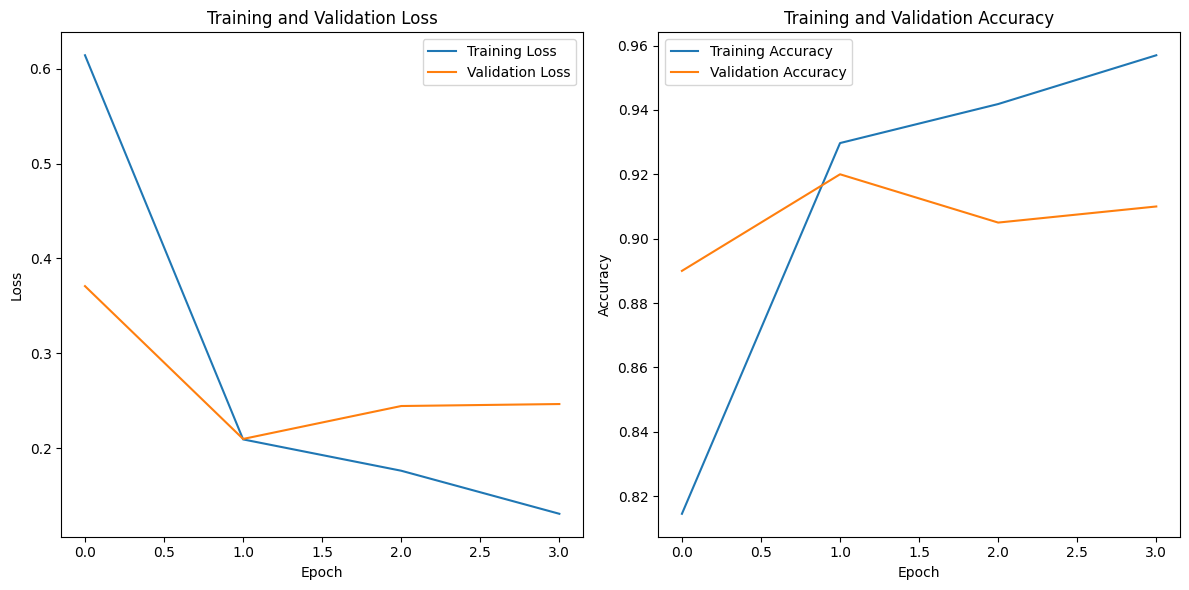

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_vals, label='Training Loss')
plt.plot(val_loss_vals, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_vals, label='Training Accuracy')
plt.plot(val_acc_vals, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Загрузка модели

In [10]:
model_path = 'best_model.keras'
model = tf.keras.models.load_model(model_path)

class_names = {
    0: 'affenpinscher', 1: 'afghan_hound', 2: 'african_hunting_dog',
    3: 'airedale', 4: 'american_staffordshire_terrier',
    5: 'appenzeller', 6: 'australian_terrier', 7: 'basenji', 8: 'basset',
    9: 'beagle'
}

### Функция для классификации изображения

In [11]:
def predict_image(image_path):
    if not os.path.exists(image_path):
        print(f"Файл {image_path} не найден.")
        return "File not found"

    img = cv2.imread(image_path)
    if img is None:
        print(f"Не удалось загрузить изображение {image_path}.")
        return "Failed to load image"

    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    predicted_label = class_names.get(predicted_class, "Unknown class")

    return predicted_label

### Классификация пород

In [17]:
image_paths = ['beagle.jpeg', 'staff.jpg']

for image_path in image_paths:
    predicted_label = predict_image(image_path)
    print(f"Предсказанный класс для {image_path}: {predicted_label}")

1/1 [==============================] - 0s 53ms/step
Предсказанный класс для beagle.jpeg: beagle
1/1 [==============================] - 0s 49ms/step
Предсказанный класс для staff.jpg: american_staffordshire_terrier
